## 1. Importing datsets

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
full_dataset3 = pd.read_csv('datasets\\full_dataset_3.csv')

## 2. Balancing data

In [3]:
def plot_count(count):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    count0 = counter[0]
    count1 = counter[1]
    total = count0 + count1
    amount = (count0/total, count1/total)

    ax.barh([0,1], amount, align='center')
    ax.set_yticks([0,1])
    ax.set_yticklabels([0,1])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('% of data')
    ax.set_ylabel('Hate detection')
    ax.set_title('Data distribution')
    
    a = round(amount[0], 3)
    ax.text(a, 0, str(a*100) + '%', color='black')
    b = round(amount[1], 3)
    ax.text(b, 1, str(b*100) + '%', color='black')

    plt.xlim([0.0, 1.0])
    plt.show()

In [4]:
counter = Counter(full_dataset3['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 1430


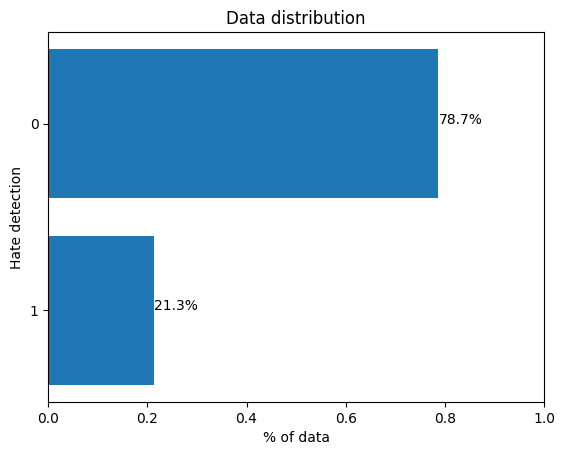

In [5]:
plot_count(counter)

In [6]:
full_dataset3_unbalanced = full_dataset3.copy()

### 2.1 Balancing through translation (oversampling)
The idea here is to translate to a random language and then back to portuguese. This will add random changes to the smaller class.

In [7]:
from textblob import TextBlob
from textblob.translate import NotTranslated
import random
from tqdm import tqdm
import time

from collections import Counter

from pandas import DataFrame
from sklearn.utils import shuffle

In [8]:
language = ["es", "de", "fr", "ar", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps", "pt"]

sr = random.SystemRandom()
def data_augmentation_translate(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in tqdm(range(0, aug_range)):
    #for j in tqdm(range(0, 1)):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        if hasattr(message, "decode"):
            message = message.decode("utf-8")
        
        text = TextBlob(message)
        try:
            text = text.translate(to=sr.choice(language))   ## Converting to random langauge for meaningful variation
            time.sleep(2)
            text = text.translate(to="pt")
        except NotTranslated:
            pass
        augmented_messages.append([str(text), 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [9]:
try:
    full_dataset3_balanced_translate = pd.read_csv('datasets\\full_dataset3_balanced_translate.csv')
except FileNotFoundError:
    full_dataset3_balanced_translate = data_augmentation_translate(full_dataset3_unbalanced)
    full_dataset3_balanced_translate.to_csv('datasets\\full_dataset3_balanced_translate.csv', index=False)

In [10]:
counter = Counter(full_dataset3_balanced_translate['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.2 Balancing through repetition (oversampling)
Now, we will just repeat some elements of the smaller class. This can generate some problems, such as skew the project.

In [11]:
def data_augmentation_repeating(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in range(aug_range):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        augmented_messages.append([message, 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [12]:
full_dataset3_balanced_repeating = data_augmentation_repeating(full_dataset3_unbalanced)

In [13]:
counter = Counter(full_dataset3_balanced_repeating['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.3 Balancing through removing random elements (downsampling)

In [14]:
def downsampling(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    df1 = dataframe[dataframe.hate_speech==class_values[1]]
    
    diff = abs(count0.text - count1.text)
    list_messages = dataframe[dataframe.hate_speech==class_values[0]]['text'].tolist()

    for j in range(diff):
        ind = random.randint(0, len(list_messages))
        del list_messages[ind-1]

    df = DataFrame({'text':list_messages, 'hate_speech': np.repeat(0, len(list_messages))})
    
    data = pd.concat([df1, df])

    return shuffle(data)

In [15]:
full_dataset3_balanced_downsampling = downsampling(full_dataset3_unbalanced)

In [16]:
counter = Counter(full_dataset3_balanced_downsampling['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 1430, Class 1: 1430


## 3. Preprocessing data

In [17]:
import nltk
#nltk.download('stopwords')
#nltk.download('rslp')
from unidecode import unidecode

In [18]:
stopwords = set(nltk.corpus.stopwords.words('portuguese')) # get stop words in portuguese

def remove_stopwords(text):
    text_without_stopwords = [word for word in text.split() if word not in stopwords]
    # some elements of the dataset were only stopwords (eg: "quando foi isso")
    # if it's the case, we'll return the same text
    if text_without_stopwords == []:
        return text
    return ' '.join(text_without_stopwords)

def cleaning_data(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'rt+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[\"!$%&\'*+,-./<=>?\():;^_`#@{|}~]', '', text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    return text

def preprocessing(text):
    #text = ' '.join(text)
    text = text.lower()
    text = cleaning_data(text)
    text = remove_stopwords(text)    
    return text


In [19]:
f = open("datasets\\lista-palavroes-bloqueio.txt", "r", encoding="utf8")
list_bad_words = f.readlines()
list_bad_words = [x.strip() for x in list_bad_words]
f.close()

def tagging_swearwords(text):
    text = [word if (word.upper() not in list_bad_words) else "_SWEARWORD" for word in text.split()]
    text = ' '.join(text)
    return text

def tagging_laughs(text):
    return re.sub(r'k{2,}|a*ha+h[ha]*|e*he+h[he]*|s*rs+r[rs]*', '_LAUGHS ', text)

def preprocessing_full(text):
    text = text.lower()
    text = cleaning_data(text)
    text = remove_stopwords(text)
    text = tagging_swearwords(text)
    text = tagging_laughs(text)
    return text

## 4. Machine learning!

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

In [21]:
# unbalanced
text3_unbalanced = full_dataset3_unbalanced['text']
class3_unbalanced = full_dataset3_unbalanced['hate_speech']

# balanced translated
text3_balanced_translate = full_dataset3_balanced_translate['text']
class3_balanced_translate = full_dataset3_balanced_translate['hate_speech']

# balanced repeating
text3_balanced_repeating = full_dataset3_balanced_repeating['text']
class3_balanced_repeating = full_dataset3_balanced_repeating['hate_speech']

# balanced downsampling
text3_balanced_downsampling = full_dataset3_balanced_downsampling['text']
class3_balanced_downsampling = full_dataset3_balanced_downsampling['hate_speech']


### 4.1 Splitting the data: train and test

In [22]:
# data = [x_train, x_test, y_train, y_test]

data3_unbalanced = train_test_split(text3_unbalanced, class3_unbalanced, test_size=0.3)

data3_balanced_translate = train_test_split(text3_balanced_translate, class3_balanced_translate, test_size=0.3)

data3_balanced_repeating = train_test_split(text3_balanced_repeating, class3_balanced_repeating, test_size=0.3)

data3_balanced_downsampling = train_test_split(text3_balanced_downsampling, class3_balanced_downsampling, test_size=0.3)

#### 4.1.1 Random Forest

In [23]:
max_depth_values = range(1, 11)
def random_forest(data):
    train_scores = []
    test_scores = []
    for i in max_depth_values:
        clf = RandomForestClassifier(max_depth=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = accuracy_score(data[2], train_predict)
        train_scores.append(train_accuracy)
        
        test_predict = pipeline.predict(data[1])
        test_accuracy = accuracy_score(data[3], test_predict)
        test_scores.append(test_accuracy)  
        
        #print('>%d, train: %.3f, test: %.3f' % (i, train_accuracy, test_accuracy))
        
    return [train_scores, test_scores]


In [24]:
scores_data3_unbalanced = random_forest(data3_unbalanced)

scores_data3_balanced_translate = random_forest(data3_balanced_translate)

scores_data3_balanced_repeating = random_forest(data3_balanced_repeating)

scores_data3_balanced_downsampling = random_forest(data3_balanced_downsampling)

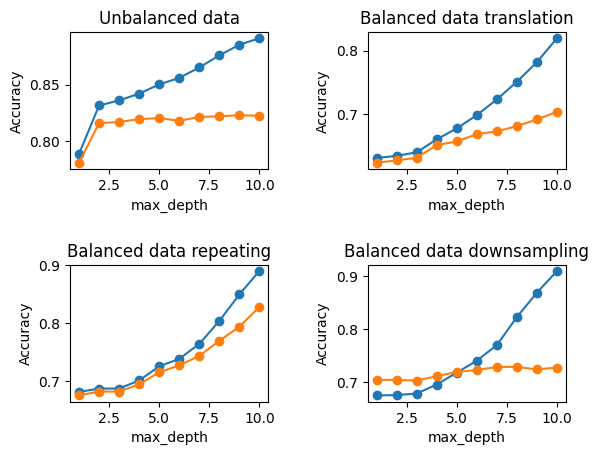

In [29]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

#### 4.1.2 Linear SVC

In [30]:
gamma_values = range(1, 100, 10)
def svc(data):
    train_scores = []
    test_scores = []
    for i in gamma_values:
        clf = SVC(gamma=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = accuracy_score(data[2], train_predict)
        train_scores.append(train_accuracy)
        
        test_predict = pipeline.predict(data[1])
        test_accuracy = accuracy_score(data[3], test_predict)
        test_scores.append(test_accuracy)    
        
    return [train_scores, test_scores]


In [31]:
scores_data3_unbalanced = svc(data3_unbalanced)

scores_data3_balanced_translate = svc(data3_balanced_translate)

scores_data3_balanced_repeating = svc(data3_balanced_repeating)

scores_data3_balanced_downsampling = svc(data3_balanced_downsampling)

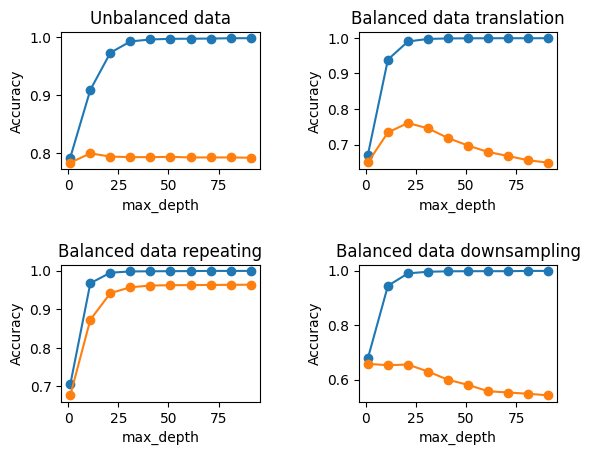

In [32]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(gamma_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(gamma_values, scores_data3_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(gamma_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(gamma_values, scores_data3_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(gamma_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(gamma_values, scores_data3_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(gamma_values, scores_data3_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(gamma_values, scores_data3_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

#### 4.1.3 Multinomial Naive Bayes

In [33]:
alpha_values = range(1, 11)
def multinomial_nb(data):
    train_scores = []
    test_scores = []
    for i in alpha_values:
        clf = MultinomialNB(alpha=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = accuracy_score(data[2], train_predict)
        train_scores.append(train_accuracy)
        
        test_predict = pipeline.predict(data[1])
        test_accuracy = accuracy_score(data[3], test_predict)
        test_scores.append(test_accuracy)    
        
    return[train_scores, test_scores]

In [34]:
scores_data3_unbalanced = multinomial_nb(data3_unbalanced)

scores_data3_balanced_translate = multinomial_nb(data3_balanced_translate)

scores_data3_balanced_repeating = multinomial_nb(data3_balanced_repeating)

scores_data3_balanced_downsampling = multinomial_nb(data3_balanced_downsampling)

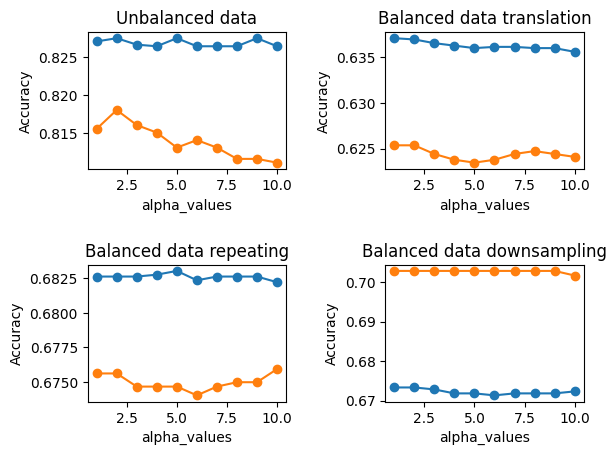

In [35]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(alpha_values, scores_data3_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(alpha_values, scores_data3_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='alpha_values', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

### 4.2 Cross-validation

In [37]:
def evaluating(pipeline_model, text, hate_speech):

    pipeline_model.fit(text, hate_speech)

    ## cross validation
    result = cross_val_predict(pipeline_model, text, hate_speech, cv=5)

    a = metrics.classification_report(hate_speech, result, labels=[0,1])
    a = a.split()

    # confusion matrix
    conf_matrix = pd.crosstab(hate_speech, result, margins=True)
    
    return a[7], a[12]

In [38]:
pipeline_LSVC_preproc = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_LSVC_preproc_full = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_LSVC_preproc_full_ngram = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full, ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ LinearSVC classifier
])



|     Models       |f1-score (0,1)  | 
| ---   ---        |   ---          |
| unbalanced       | (0,0)          |
| bal_rep          | (1,0)          |
| bal_trans        | (2,0)          |
| bal_down         | (3,0)          |

In [39]:
res_LVC = np.zeros((4, 4))

print('LINEAR SVC')

# hatespeech3, preproc
print('1. Hatespeech3 without laughs and swearword labels')
print('1.1. Unbalanced data')
res_LVC[0][0], res_LVC[0][1] = evaluating(pipeline_LSVC_preproc, text3_unbalanced, class3_unbalanced)
print('1.2. Balanced data - repeating data')
res_LVC[1][0], res_LVC[1][1] = evaluating(pipeline_LSVC_preproc, text3_balanced_repeating, class3_balanced_repeating)
print('1.3. Balanced data - translation')
res_LVC[2][0], res_LVC[2][1] = evaluating(pipeline_LSVC_preproc, text3_balanced_translate, class3_balanced_translate)
print('1.4. Balanced data - downsampling')
res_LVC[3][0], res_LVC[3][1] = evaluating(pipeline_LSVC_preproc, text3_balanced_downsampling, class3_balanced_downsampling)

# hatespeech3, preproc_full
print('2. Hatespeech3 with laughs and swearword labels')
print('2.1. Unbalanced data')
res_LVC[0][2], res_LVC[0][3] = evaluating(pipeline_LSVC_preproc_full, text3_unbalanced, class3_unbalanced)
print('2.2. Balanced data - repeating data')
res_LVC[1][2], res_LVC[1][3] = evaluating(pipeline_LSVC_preproc_full, text3_balanced_repeating, class3_balanced_repeating)
print('2.3. Balanced data - translation')
res_LVC[2][2], res_LVC[2][3] = evaluating(pipeline_LSVC_preproc_full, text3_balanced_translate, class3_balanced_translate)
print('2.4. Balanced data - downsampling')
res_LVC[3][2], res_LVC[3][3] = evaluating(pipeline_LSVC_preproc_full, text3_balanced_downsampling, class3_balanced_downsampling)

LINEAR SVC
1. Hatespeech3 without laughs and swearword labels
1.1. Unbalanced data
1.2. Balanced data - repeating data
1.3. Balanced data - translation
1.4. Balanced data - downsampling
2. Hatespeech3 with laughs and swearword labels
2.1. Unbalanced data
2.2. Balanced data - repeating data
2.3. Balanced data - translation
2.4. Balanced data - downsampling


In [40]:
res_LVC

array([[0.88, 0.05, 0.89, 0.46],
       [0.64, 0.63, 0.74, 0.68],
       [0.62, 0.61, 0.7 , 0.63],
       [0.63, 0.62, 0.73, 0.66]])

In [41]:
pipeline_RF_preproc = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ LinearSVC classifier
])


pipeline_RF_preproc_full = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ LinearSVC classifier
])



In [42]:
res_RF = np.zeros((4, 4))


# hatespeech3, preproc
print('1. Hatespeech3 without laughs and swearword labels')
print('1.1. Unbalanced data')
res_RF[0][0], res_RF[0][1] = evaluating(pipeline_RF_preproc, text3_unbalanced, class3_unbalanced)
print('1.2. Balanced data - repeating data')
res_RF[1][0], res_RF[1][1] = evaluating(pipeline_RF_preproc, text3_balanced_repeating, class3_balanced_repeating)
print('1.3. Balanced data - translation')
res_RF[2][0], res_RF[2][1] = evaluating(pipeline_RF_preproc, text3_balanced_translate, class3_balanced_translate)
print('1.4. Balanced data - downsampling')
res_RF[3][0], res_RF[3][1] = evaluating(pipeline_RF_preproc, text3_balanced_downsampling, class3_balanced_downsampling)

# hatespeech3, preproc_full
print('2. Hatespeech3 with laughs and swearword labels')
print('2.1. Unbalanced data')
res_RF[0][2], res_RF[0][3] = evaluating(pipeline_RF_preproc_full, text3_unbalanced, class3_unbalanced)
print('2.2. Balanced data - repeating data')
res_RF[1][2], res_RF[1][3] = evaluating(pipeline_RF_preproc_full, text3_balanced_repeating, class3_balanced_repeating)
print('2.3. Balanced data - translation')
res_RF[2][2], res_RF[2][3] = evaluating(pipeline_RF_preproc_full, text3_balanced_translate, class3_balanced_translate)
print('2.4. Balanced data - downsampling')
res_RF[3][2], res_RF[3][3] = evaluating(pipeline_RF_preproc_full, text3_balanced_downsampling, class3_balanced_downsampling)

1. Hatespeech3 without laughs and swearword labels
1.1. Unbalanced data
1.2. Balanced data - repeating data
1.3. Balanced data - translation
1.4. Balanced data - downsampling
2. Hatespeech3 with laughs and swearword labels
2.1. Unbalanced data
2.2. Balanced data - repeating data
2.3. Balanced data - translation
2.4. Balanced data - downsampling


In [43]:
res_RF

array([[0.88, 0.14, 0.89, 0.45],
       [0.96, 0.96, 0.95, 0.95],
       [0.74, 0.72, 0.78, 0.74],
       [0.65, 0.63, 0.74, 0.66]])

In [44]:
pipeline_MNB_preproc = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_MNB_preproc_full = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_MNB_preproc_full_ngram = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full, ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LinearSVC classifier
])


In [45]:
res_MNB = np.zeros((4, 4))

print('MULTINOMIAL NAIVE BAYES')

# hatespeech3, preproc
print('1. Hatespeech3 without laughs and swearword labels')
print('1.1. Unbalanced data')
res_MNB[0][0], res_MNB[0][1] = evaluating(pipeline_MNB_preproc, text3_unbalanced, class3_unbalanced)
print('1.2. Balanced data - repeating data')
res_MNB[1][0], res_MNB[1][1] = evaluating(pipeline_MNB_preproc, text3_balanced_repeating, class3_balanced_repeating)
print('1.3. Balanced data - translation')
res_MNB[2][0], res_MNB[2][1] = evaluating(pipeline_MNB_preproc, text3_balanced_translate, class3_balanced_translate)
print('1.4. Balanced data - downsampling')
res_MNB[3][0], res_MNB[3][1] = evaluating(pipeline_MNB_preproc, text3_balanced_downsampling, class3_balanced_downsampling)

# hatespeech3, preproc_full
print('2. Hatespeech3 with laughs and swearword labels')
print('2.1. Unbalanced data')
res_MNB[0][2], res_MNB[0][3] = evaluating(pipeline_MNB_preproc_full, text3_unbalanced, class3_unbalanced)
print('2.2. Balanced data - repeating data')
res_MNB[1][2], res_MNB[1][3] = evaluating(pipeline_MNB_preproc_full, text3_balanced_repeating, class3_balanced_repeating)
print('2.3. Balanced data - translation')
res_MNB[2][2], res_MNB[2][3] = evaluating(pipeline_MNB_preproc_full, text3_balanced_translate, class3_balanced_translate)
print('2.4. Balanced data - downsampling')
res_MNB[3][2], res_MNB[3][3] = evaluating(pipeline_MNB_preproc_full, text3_balanced_downsampling, class3_balanced_downsampling)

MULTINOMIAL NAIVE BAYES
1. Hatespeech3 without laughs and swearword labels
1.1. Unbalanced data
1.2. Balanced data - repeating data
1.3. Balanced data - translation
1.4. Balanced data - downsampling
2. Hatespeech3 with laughs and swearword labels
2.1. Unbalanced data
2.2. Balanced data - repeating data
2.3. Balanced data - translation
2.4. Balanced data - downsampling


In [46]:
res_MNB

array([[0.88, 0.  , 0.89, 0.46],
       [0.65, 0.59, 0.74, 0.59],
       [0.65, 0.52, 0.71, 0.5 ],
       [0.64, 0.55, 0.74, 0.6 ]])

In [47]:
res_RF

array([[0.88, 0.14, 0.89, 0.45],
       [0.96, 0.96, 0.95, 0.95],
       [0.74, 0.72, 0.78, 0.74],
       [0.65, 0.63, 0.74, 0.66]])

In [48]:
res_LVC

array([[0.88, 0.05, 0.89, 0.46],
       [0.64, 0.63, 0.74, 0.68],
       [0.62, 0.61, 0.7 , 0.63],
       [0.63, 0.62, 0.73, 0.66]])